In [3]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img

# Directories
train_dir = r"C:\Users\CVR\Desktop\DataSet\Herlev Dataset\train"
test_dir = r"C:\Users\CVR\Desktop\DataSet\Herlev Dataset\train"
augmented_train_dir = r"C:\Users\CVR\Desktop\DataSet\Herlev Dataset\augmented_train"
augmented_test_dir = r"C:\Users\CVR\Desktop\DataSet\Herlev Dataset\augmented_test"

# Create augmented folders if they don't exist
os.makedirs(augmented_train_dir, exist_ok=True)
os.makedirs(augmented_test_dir, exist_ok=True)

# Augmentation settings
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_images(src_dir, dest_dir, augment_count=5):
    for class_name in os.listdir(src_dir):
        class_path = os.path.join(src_dir, class_name)
        save_path = os.path.join(dest_dir, class_name)
        os.makedirs(save_path, exist_ok=True)

        if not os.path.isdir(class_path):
            continue

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path)  # Load image
            x = img_to_array(img)     # Convert to array
            x = x.reshape((1,) + x.shape)

            # Generate and save augmented images
            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=save_path, save_prefix='aug', save_format='jpg'):
                i += 1
                if i >= augment_count:
                    break

# Apply augmentation
print("Augmenting training data...")
augment_images(train_dir, augmented_train_dir)

print("Augmenting test data...")
augment_images(test_dir, augmented_test_dir)

print("Data augmentation completed.")

Augmenting training data...
Augmenting test data...
Data augmentation completed.


In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ——— GazelleOptimizer with Lévy flight & Brownian motion ——————————
def levy_brownian_step(prob_brownian=0.3, lam=1.5, size=1):
    if np.random.rand() < prob_brownian:
        return np.random.normal(0, 0.1, size)
    else:
        sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
                     (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)
        u = np.random.normal(0, sigma_levy, size)
        v = np.random.normal(0, 1, size)
        return u/(np.abs(v)**(1/lam))

class GazelleOptimizer(optim.Optimizer):
    def __init__(self, params, lr=0.001, momentum=0.9, exploration_factor=0.1,
                 num_gazelles=10, prob_brownian=0.3):
        defaults = dict(lr=lr, momentum=momentum,
                        exploration_factor=exploration_factor,
                        num_gazelles=num_gazelles)
        super().__init__(params, defaults)
        self.prob_brownian = prob_brownian
        self.gazelles = None

    def initialize_population(self, shape, device, dtype):
        lb, ub = -1., 1.
        self.gazelles = torch.empty(
            (self.defaults['num_gazelles'], *shape),
            device=device, dtype=dtype
        ).uniform_(lb, ub)

    def step(self, closure=None):
        loss = closure() if closure else None
        for group in self.param_groups:
            lr = group['lr']
            m = group['momentum']
            ef = group['exploration_factor']
            ng = group['num_gazelles']

            for p in group['params']:
                if p.grad is None: continue
                d = p.grad.data
                shape = d.shape

                if self.gazelles is None or self.gazelles.shape[1:] != shape:
                    self.initialize_population(shape, p.device, p.dtype)

                vec = torch.tensor(
                    levy_brownian_step(self.prob_brownian, size=d.numel()),
                    device=p.device, dtype=p.dtype
                ).view_as(d).detach()

                for i in range(ng):
                    self.gazelles[i].add_(ef * vec).clamp_(-1., 1.)

                buf = self.state[p].get('momentum_buffer', None)
                if buf is None:
                    buf = d.clone()
                    self.state[p]['momentum_buffer'] = buf
                else:
                    buf.mul_(m).add_(d)
                elite = self.gazelles.mean(0)
                p.data.add_( -(buf + ef*elite) * lr )
        return loss

In [7]:
# ——— Data Preparation —————————————————————————————————————————————
dataset_path = r"C:\Users\CVR\Desktop\DataSet\Herlev Dataset\augmented_train"
batch_size, num_classes = 32, 7
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
dataset = datasets.ImageFolder(dataset_path, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def create_model(name, num_classes):
    if name == 'squeezenet1_1':
        model = models.squeezenet1_1(pretrained=True)
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)
        model.num_classes = num_classes

    elif name == 'resnet18':
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif name == 'vgg16':
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

    elif name == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    else:
        raise ValueError(f"Unsupported model name: {name}")

    return model.to(device)

In [11]:
num_classes = 7  # adjust for your classification problem
model_names = ['squeezenet1_1', 'resnet18', 'vgg16', 'mobilenet_v2']

# Create models with distinct names
models_dict = {}
for name in model_names:
    model = create_model(name, num_classes)
    models_dict[name] = model
# ——— Training & Evaluation Functions —————————————————————————————————
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)
    return total_loss/total, correct/total

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, all_preds, all_labels = 0, [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            out = model(inputs)
            loss = criterion(out, labels)
            total_loss += loss.item() * inputs.size(0)
            preds = out.argmax(1)
            all_preds += preds.cpu().tolist()
            all_labels += labels.cpu().tolist()

    metrics = {
        'loss': total_loss/len(loader.dataset),
        'accuracy': accuracy_score(all_labels, all_preds),
        'precision': precision_score(all_labels, all_preds, average='weighted'),
        'recall': recall_score(all_labels, all_preds, average='weighted'),
        'f1': f1_score(all_labels, all_preds, average='weighted'),
        'mcc': matthews_corrcoef(all_labels, all_preds)
    }
    return metrics

C:\Users\CVR\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\CVR\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\CVR\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up

In [12]:
# ——— Training Loop Across Models ——————————————————————————————————
num_epochs, lr = 20, 0.001
histories, final_metrics = {}, {}

for name, model in models_dict.items():
    print(f"\n=== Training {name} ===")
    optimizer = GazelleOptimizer(model.parameters(), lr=lr, momentum=0.9,
                                 exploration_factor=0.1, prob_brownian=0.3)
    criterion = nn.CrossEntropyLoss()
    h = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

    for ep in range(num_epochs):
        tl, ta = train_one_epoch(model, train_loader, optimizer, criterion)
        vm = evaluate(model, val_loader, criterion)
        h['train_loss'].append(tl)
        h['val_loss'].append(vm['loss'])
        h['train_acc'].append(ta)
        h['val_acc'].append(vm['accuracy'])
        print(f"Ep {ep+1}/{num_epochs}: train_loss={tl:.4f}, train_acc={ta:.4f}, val_acc={vm['accuracy']:.4f}")

    histories[name] = h
    final_metrics[name] = evaluate(model, val_loader, criterion)


=== Training squeezenet1_1 ===


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 1/20: train_loss=1.2816, train_acc=0.5052, val_acc=0.5913


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 2/20: train_loss=0.8886, train_acc=0.6482, val_acc=0.6843


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 3/20: train_loss=0.6909, train_acc=0.7372, val_acc=0.7163


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 4/20: train_loss=0.6155, train_acc=0.7648, val_acc=0.7003


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 5/20: train_loss=0.5562, train_acc=0.7788, val_acc=0.7949


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 6/20: train_loss=0.4746, train_acc=0.8221, val_acc=0.7804


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 7/20: train_loss=0.3907, train_acc=0.8510, val_acc=0.8173


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 8/20: train_loss=0.2919, train_acc=0.8938, val_acc=0.8013


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 9/20: train_loss=0.3054, train_acc=0.8882, val_acc=0.8141


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 10/20: train_loss=0.2266, train_acc=0.9183, val_acc=0.8750


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 11/20: train_loss=0.2525, train_acc=0.9067, val_acc=0.8526


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 12/20: train_loss=0.2265, train_acc=0.9227, val_acc=0.8397


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 13/20: train_loss=0.1802, train_acc=0.9339, val_acc=0.8317


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 14/20: train_loss=0.2355, train_acc=0.9147, val_acc=0.7981


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 15/20: train_loss=0.1863, train_acc=0.9327, val_acc=0.8429


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 16/20: train_loss=0.0856, train_acc=0.9704, val_acc=0.8862


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 17/20: train_loss=0.0690, train_acc=0.9784, val_acc=0.8590


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 18/20: train_loss=0.1727, train_acc=0.9307, val_acc=0.8381


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 19/20: train_loss=0.1176, train_acc=0.9611, val_acc=0.8574


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 20/20: train_loss=0.0663, train_acc=0.9772, val_acc=0.8862

=== Training resnet18 ===


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 1/20: train_loss=1.2528, train_acc=0.5312, val_acc=0.6506


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 2/20: train_loss=0.6778, train_acc=0.7612, val_acc=0.7660


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 3/20: train_loss=0.4244, train_acc=0.8658, val_acc=0.8317


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 4/20: train_loss=0.2929, train_acc=0.9167, val_acc=0.8590


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 5/20: train_loss=0.1546, train_acc=0.9716, val_acc=0.8862


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 6/20: train_loss=0.0927, train_acc=0.9900, val_acc=0.8766


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 7/20: train_loss=0.0717, train_acc=0.9916, val_acc=0.8878


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 8/20: train_loss=0.0493, train_acc=0.9956, val_acc=0.9087


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 9/20: train_loss=0.0383, train_acc=0.9956, val_acc=0.8926


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 10/20: train_loss=0.0293, train_acc=0.9984, val_acc=0.9087


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 11/20: train_loss=0.0263, train_acc=0.9976, val_acc=0.9263


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 12/20: train_loss=0.0214, train_acc=0.9988, val_acc=0.9087


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 13/20: train_loss=0.0189, train_acc=0.9992, val_acc=0.9071


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 14/20: train_loss=0.0177, train_acc=0.9996, val_acc=0.9151


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 15/20: train_loss=0.0122, train_acc=1.0000, val_acc=0.9215


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 16/20: train_loss=0.0099, train_acc=0.9996, val_acc=0.9279


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 17/20: train_loss=0.0096, train_acc=1.0000, val_acc=0.9231


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 18/20: train_loss=0.0093, train_acc=1.0000, val_acc=0.9263


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 19/20: train_loss=0.0081, train_acc=1.0000, val_acc=0.9119


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 20/20: train_loss=0.0082, train_acc=1.0000, val_acc=0.9247

=== Training vgg16 ===


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 1/20: train_loss=1.2126, train_acc=0.5172, val_acc=0.6186


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 2/20: train_loss=0.7767, train_acc=0.6963, val_acc=0.6795


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 3/20: train_loss=0.5719, train_acc=0.7829, val_acc=0.8109


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 4/20: train_loss=0.3619, train_acc=0.8670, val_acc=0.8093


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 5/20: train_loss=0.2692, train_acc=0.8930, val_acc=0.8638


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 6/20: train_loss=0.1926, train_acc=0.9311, val_acc=0.8397


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 7/20: train_loss=0.1635, train_acc=0.9435, val_acc=0.8622


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 8/20: train_loss=0.1024, train_acc=0.9683, val_acc=0.8894


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 9/20: train_loss=0.0799, train_acc=0.9744, val_acc=0.8510


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 10/20: train_loss=0.0867, train_acc=0.9724, val_acc=0.9135


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 11/20: train_loss=0.0571, train_acc=0.9776, val_acc=0.8974


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 12/20: train_loss=0.0301, train_acc=0.9904, val_acc=0.9183


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 13/20: train_loss=0.0419, train_acc=0.9864, val_acc=0.8846


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 14/20: train_loss=0.0360, train_acc=0.9864, val_acc=0.8958


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 15/20: train_loss=0.0460, train_acc=0.9824, val_acc=0.8702


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 16/20: train_loss=0.0459, train_acc=0.9856, val_acc=0.9199


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 17/20: train_loss=0.0134, train_acc=0.9964, val_acc=0.9375


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 18/20: train_loss=0.0037, train_acc=0.9988, val_acc=0.9311


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 19/20: train_loss=0.0013, train_acc=1.0000, val_acc=0.9279


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 20/20: train_loss=0.0009, train_acc=1.0000, val_acc=0.9359

=== Training mobilenet_v2 ===


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 1/20: train_loss=1.2277, train_acc=0.5256, val_acc=0.6795


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 2/20: train_loss=0.6481, train_acc=0.7544, val_acc=0.7772


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 3/20: train_loss=0.4311, train_acc=0.8454, val_acc=0.7949


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 4/20: train_loss=0.2794, train_acc=0.9127, val_acc=0.8766


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 5/20: train_loss=0.1598, train_acc=0.9547, val_acc=0.8670


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 6/20: train_loss=0.1155, train_acc=0.9724, val_acc=0.8702


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 7/20: train_loss=0.0894, train_acc=0.9764, val_acc=0.8766


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 8/20: train_loss=0.0510, train_acc=0.9908, val_acc=0.8878


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 9/20: train_loss=0.0522, train_acc=0.9884, val_acc=0.8670


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 10/20: train_loss=0.0504, train_acc=0.9868, val_acc=0.9103


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 11/20: train_loss=0.0308, train_acc=0.9920, val_acc=0.8878


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 12/20: train_loss=0.0263, train_acc=0.9952, val_acc=0.9199


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 13/20: train_loss=0.0226, train_acc=0.9952, val_acc=0.9311


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 14/20: train_loss=0.0179, train_acc=0.9972, val_acc=0.9119


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 15/20: train_loss=0.0132, train_acc=0.9996, val_acc=0.9183


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 16/20: train_loss=0.0092, train_acc=0.9988, val_acc=0.9311


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 17/20: train_loss=0.0108, train_acc=0.9980, val_acc=0.9295


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 18/20: train_loss=0.0187, train_acc=0.9960, val_acc=0.9199


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 19/20: train_loss=0.0107, train_acc=0.9980, val_acc=0.9279


C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  sigma_levy = (np.math.gamma(1+lam) * np.sin(np.pi*lam/2) /
C:\Users\CVR\AppData\Local\Temp\ipykernel_14496\4281753202.py:17: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  (np.math.gamma((1+lam)/2)*lam*2**((lam-1)/2)))**(1/lam)


Ep 20/20: train_loss=0.0087, train_acc=0.9996, val_acc=0.9183


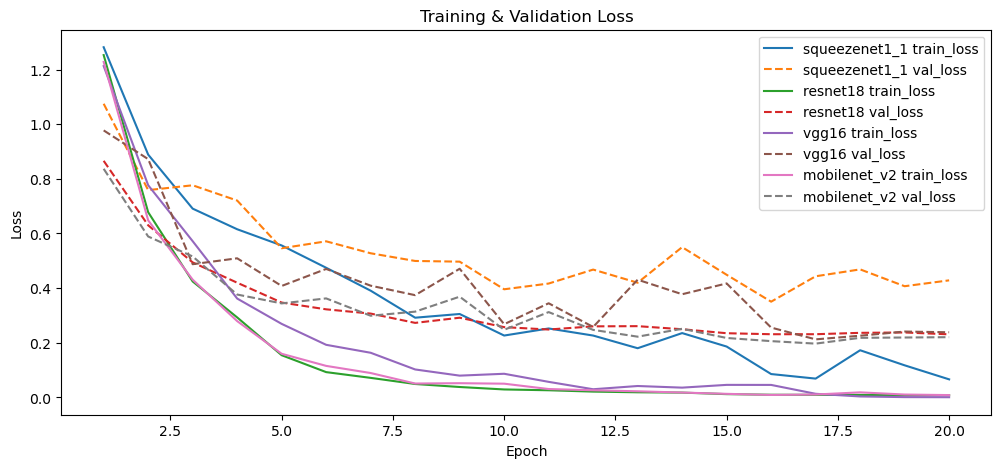

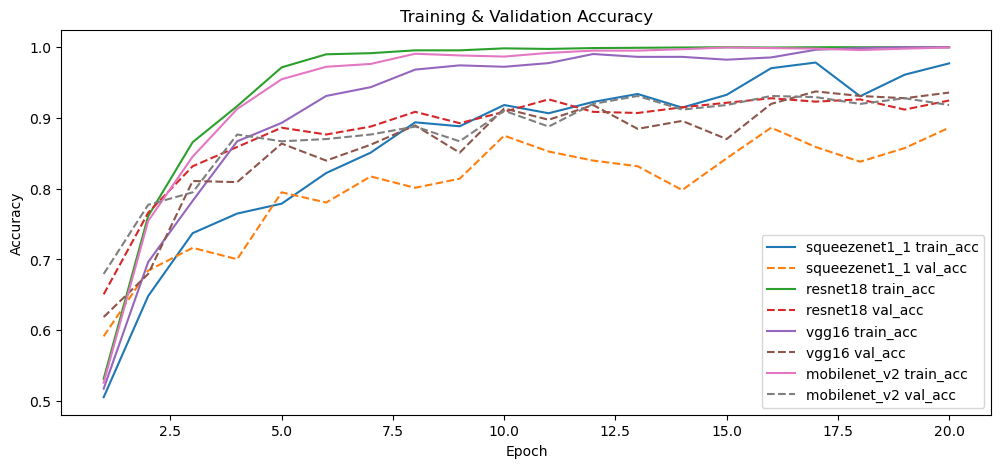

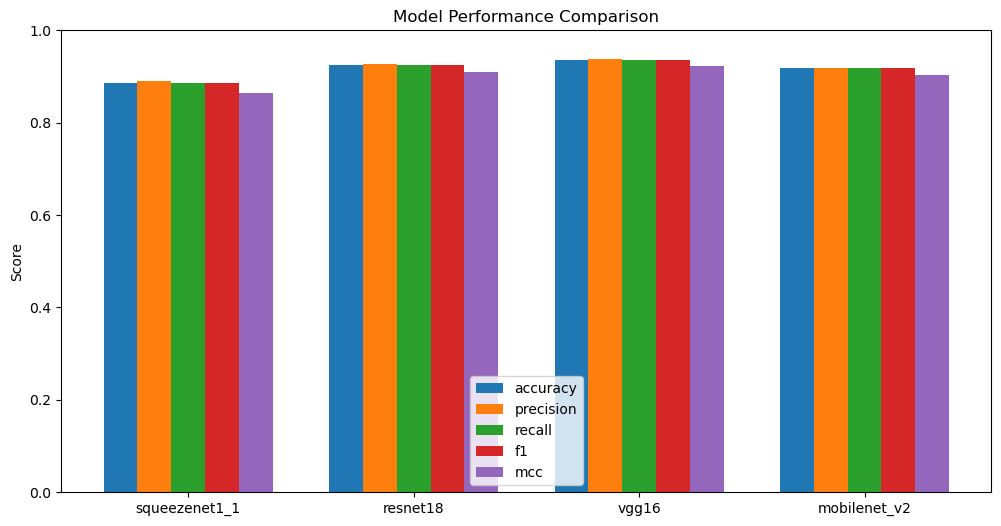

In [13]:
# ——— Visualization —————————————————————————————————————————————
epochs = range(1, num_epochs+1)
plt.figure(figsize=(12,5))
for name, h in histories.items():
    plt.plot(epochs, h['train_loss'], label=f'{name} train_loss')
    plt.plot(epochs, h['val_loss'], '--', label=f'{name} val_loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training & Validation Loss'); plt.legend(); plt.show()

plt.figure(figsize=(12,5))
for name, h in histories.items():
    plt.plot(epochs, h['train_acc'], label=f'{name} train_acc')
    plt.plot(epochs, h['val_acc'], '--', label=f'{name} val_acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Training & Validation Accuracy'); plt.legend(); plt.show()

# Bar chart of final metrics
metrics_list = ['accuracy','precision','recall','f1','mcc']
n_models = len(model_names)
bar_width, indices = 0.15, np.arange(n_models)
plt.figure(figsize=(12,6))
for i, metric in enumerate(metrics_list):
    vals = [final_metrics[m][metric] for m in model_names]
    plt.bar(indices + i*bar_width, vals, width=bar_width, label=metric)
plt.xticks(indices + bar_width*2, model_names)
plt.ylim(0,1)
plt.ylabel('Score'); plt.title('Model Performance Comparison'); plt.legend(); plt.show()
